In [1]:
# install the follwoing packages in the enviroment:
# python3 -m pip install pandas
# python3 -m pip install seaborn

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import numpy as np
import json

import os

## Hypotheses to be tested

#### As reference values to compare to, we will use demographics from ECS from agu, egu, ssa. This will give an idea of how many of the active scientists at these professional levels are represented to the peer-reviewed articles (which is the main crucial factor for career advancing and perhaps the daily goal of most academics)

FIRST GLANCES AT DATA

- % of female first authors (hists?)
- % publications with all male vs. % publications with all female authors (hists?)

CO-AUTHORSHIP ANALYSES

- When 1st author is female: % of male vs. female co-authors (bars..?)
- When 1st author is female: likelihood of last author (possibly PI) to be female vs. male 
- When 1st author is male: % of female coauthors and % of male coauthors
- When the last name is female (possible PI), is there a higher % of female co-authors vs. male ones?

JOURNAL IF ANALYSES:

- Correlation between IF and female first authors: does higher IF mean fewer female first authors?




In [2]:
# Define local paths

root = ! pwd
root = root[0]

RAW_DIR=root+"/author_allgenders/"  # TODO: change this with the final json files obtained from parsing

if not os.path.exists(RAW_DIR):
    print("The directory {} does not exist.\nThere is no raw data for statistical analysis.".format(RAW_DIR))

In [3]:
## read all json files and create a dataframe

dfs = [] 

for _, _, files in os.walk(RAW_DIR):
    for file in files:
        with open(RAW_DIR+file) as f:
            data = json.loads(f.read())
            df = pd.json_normalize(data)
            df = df.drop(columns=['first_author','all_names', 'year', 'month', 'title', 'id'])
            dfs.append(df)

df = pd.concat(dfs, ignore_index=True)
df

,journal,all_genders,all_percent
0,GEOPHYSICS,"[male, male, male, male]","[0.98, 0.98, 0.99, 0.98]"
1,G3,"[female, male, male, male]","[0.99, 0.98, 0.98, 0.95]"
2,Bulletin+of+the+Seismological+Society+of+America,"[male, female, female]","[0.67, 0.63, 0.5042013788647864]"
3,JGRSolidEarth,"[male, female, male, male, male]","[0.98, 0.98, 0.99, 0.69, 0.99]"
4,E%26PSL,"[male, male, male, male, male]","[0.98, 0.99, 0.98, 0.99, 0.99]"
...,...,...,...
19355,E%26PSL,"[male, male]","[1.0, 1.0]"
19356,E%26PSL,"[male, male, female, male]","[0.93, 0.99, 0.98, 0.97]"
19357,JGRSolidEarth,"[female, female, male, female]","[0.98, 0.99, 0.98, 0.97]"
19358,Bulletin+of+the+Seismological+Society+of+America,"[male, male, male, male]","[0.74, 0.99, 0.99, 0.98]"


### Create new columns in the dataframe extracting useful information from list of coauthors

In [8]:
# Number of authors:

df['Number_authors'] = df['all_genders'].apply(lambda x: len(x)) #take the length of the list all_genders

# First author's gender and percentage:

df['First_Author_gend'] = df['all_genders'].apply(lambda x: x[0]) #take the first element of the list all_genders
df['First_Author_perc'] = df['all_percent'].apply(lambda x: x[0])

# Last author's gender and percentage:

df['Last_Author_gend'] = df['all_genders'].apply(lambda x: x[-1]) #take the last element of the list all_genders
df['Last_Author_perc'] = df['all_percent'].apply(lambda x: x[-1])

df

,journal,all_genders,all_percent,Number_authors,First_Author_gend,First_Author_perc,Last_Author_gend,Last_Author_perc,Last_Author_probF,First_Author_probF
0,GEOPHYSICS,"[male, male, male, male]","[0.98, 0.98, 0.99, 0.98]",4,male,0.98,male,0.980000,0.020000,0.02
1,G3,"[female, male, male, male]","[0.99, 0.98, 0.98, 0.95]",4,female,0.99,male,0.950000,0.050000,0.99
2,Bulletin+of+the+Seismological+Society+of+America,"[male, female, female]","[0.67, 0.63, 0.5042013788647864]",3,male,0.67,female,0.504201,0.504201,0.33
3,JGRSolidEarth,"[male, female, male, male, male]","[0.98, 0.98, 0.99, 0.69, 0.99]",5,male,0.98,male,0.990000,0.010000,0.02
4,E%26PSL,"[male, male, male, male, male]","[0.98, 0.99, 0.98, 0.99, 0.99]",5,male,0.98,male,0.990000,0.010000,0.02
...,...,...,...,...,...,...,...,...,...,...
19355,E%26PSL,"[male, male]","[1.0, 1.0]",2,male,1.00,male,1.000000,0.000000,0.00
19356,E%26PSL,"[male, male, female, male]","[0.93, 0.99, 0.98, 0.97]",4,male,0.93,male,0.970000,0.030000,0.07
19357,JGRSolidEarth,"[female, female, male, female]","[0.98, 0.99, 0.98, 0.97]",4,female,0.98,female,0.970000,0.970000,0.98
19358,Bulletin+of+the+Seismological+Society+of+America,"[male, male, male, male]","[0.74, 0.99, 0.99, 0.98]",4,male,0.74,male,0.980000,0.020000,0.26


 #### It is easier if the all probabilities are with respect to the same gender (female)

In [12]:
# prob(female) = 1 - prob(male)

# Prob last author female:

df['Last_Author_probF'] = df['Last_Author_perc']
df.loc[df['Last_Author_gend'] == 'male','Last_Author_probF'] = \
    1 - df.loc[df['Last_Author_gend'] == 'male','Last_Author_probF']

# Prob first author female:

df['First_Author_probF'] = df['First_Author_perc']
df.loc[df['First_Author_gend'] == 'male','First_Author_probF'] = \
    1 - df.loc[df['First_Author_gend'] == 'male','First_Author_probF']

df

,journal,all_genders,all_percent,Number_authors,First_Author_gend,First_Author_perc,Last_Author_gend,Last_Author_perc,Last_Author_probF,First_Author_probF
0,GEOPHYSICS,"[male, male, male, male]","[0.98, 0.98, 0.99, 0.98]",4,male,0.98,male,0.980000,0.020000,0.02
1,G3,"[female, male, male, male]","[0.99, 0.98, 0.98, 0.95]",4,female,0.99,male,0.950000,0.050000,0.99
2,Bulletin+of+the+Seismological+Society+of+America,"[male, female, female]","[0.67, 0.63, 0.5042013788647864]",3,male,0.67,female,0.504201,0.504201,0.33
3,JGRSolidEarth,"[male, female, male, male, male]","[0.98, 0.98, 0.99, 0.69, 0.99]",5,male,0.98,male,0.990000,0.010000,0.02
4,E%26PSL,"[male, male, male, male, male]","[0.98, 0.99, 0.98, 0.99, 0.99]",5,male,0.98,male,0.990000,0.010000,0.02
...,...,...,...,...,...,...,...,...,...,...
19355,E%26PSL,"[male, male]","[1.0, 1.0]",2,male,1.00,male,1.000000,0.000000,0.00
19356,E%26PSL,"[male, male, female, male]","[0.93, 0.99, 0.98, 0.97]",4,male,0.93,male,0.970000,0.030000,0.07
19357,JGRSolidEarth,"[female, female, male, female]","[0.98, 0.99, 0.98, 0.97]",4,female,0.98,female,0.970000,0.970000,0.98
19358,Bulletin+of+the+Seismological+Society+of+America,"[male, male, male, male]","[0.74, 0.99, 0.99, 0.98]",4,male,0.74,male,0.980000,0.020000,0.26


## Now we can compute some interesting probabilities:

### Useful formulas:

#### Suppose $x_i$ refers to the article $i$ and $N$ is the total number of articles. Then, the probability of an article having female author is:

$$p(\text{female}) = \sum_{i}^N p(\text{female}|x_i) p(x_i) $$.

#### If we have all the probabilities with respect to the female gender, then the probability of having a male author will be:

$$p(\text{male}) = \sum_{i}^N (1 - p(\text{female}|x_i)) p(x_i) $$.

#### $p(x_i)$ is the probability of the article $x_i$. All articles have the same probability, therefore $p(x_i) = \frac{1}{N}$. This means that the formulas above are same as taking the average of  $p(\text{female}|x_i)$ or $(1 - p(\text{female}|x_i))$, respectively.


### Let's compute some easy statistics to start

In [7]:
print('Probability of having a female first author:', df['First_Author_probF'].sum()/df.shape[0])
print('Probability of having a male first author:', (1 - df['First_Author_probF']).sum()/df.shape[0])


print('Probability of having a female last author:', df['Last_Author_probF'].sum()/df.shape[0])
print('Probability of having a male last author:', (1 - df['Last_Author_probF']).sum()/df.shape[0])



Probability of having a female first author: 0.26617682599020004
Probability of having a male first author: 0.6995773062412051
Probability of having a female last author: 0.1847974917220097
Probability of having a male last author: 0.7800785413358415


In [70]:
## Count female and male first authors at all articles

f_last = len(df[df['Last_Author_gend'] == 'female'])
m_last = len(df[df['Last_Author_gend'] == 'male'])
print(f_last)
print(m_last)


f_first = len(df[df['First_Author_gend'] == 'female'])
m_first = len(df[df['First_Author_gend'] == 'male'])
print(f_first)
print(m_first)


3101
15578
4694
14003


[16.601531131216873]
[83.39846886878313]
[74.89436808044071]
[25.105631919559286]
[array([83.]), array([17.]), array([75.]), array([25.])]


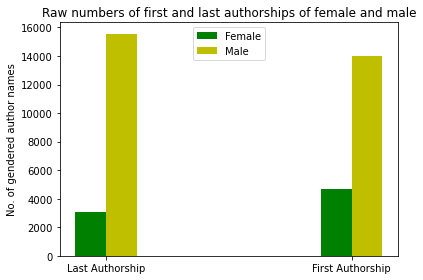

In [120]:
# Create a basic plot for last and first authors percentages for all articles

sum_last = f_last + m_last
sum_first = f_first + m_first
f_lastpc = [(f_last)*100/sum_last]
print(f_lastpc)
m_lastpc = [(m_last)*100/sum_last]
print(m_lastpc)
m_firstpc = [(m_first)*100/sum_first]
print(m_firstpc)
f_firstpc = [(f_first)*100/sum_first]
print(f_firstpc)


labels = ['Last Authorship', 'First Authorship']
dataF= [f_last, f_first]
dataM = [m_last, m_first]


x = np.arange(len(labels))  # the label locations
width = 0.125  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, dataF, width, label='Female',color='g')
rects2 = ax.bar(x + width/2, dataM, width, label='Male',color='y')

x_labels = [np.rint(m_lastpc),np.rint(f_lastpc),np.rint(m_firstpc),np.rint(f_firstpc)]
print(x_labels)
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('No. of gendered author names')
ax.set_title('Raw numbers of first and last authorships of female and male')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(loc='upper center')

# def autolabel(rects, xpos='center'):
#     """
#     Attach a text label above each bar in *rects*, displaying its height.

#     *xpos* indicates which side to place the text w.r.t. the center of
#     the bar. It can be one of the following {'center', 'right', 'left'}.
#     """

#     ha = {'center': 'center', 'right': 'left', 'left': 'right'}
#     offset = {'center': 0, 'right': 1, 'left': -1}

#     for rect in rects:
#         height = rect.get_height()
#         ax.annotate('{}'.format(height),
#                     xy=(rect.get_x() + rect.get_width() / 2, height),
#                     xytext=(offset[xpos]*3, 3),  # use 3 points offset
#                     textcoords="offset points",  # in both directions
#                     ha=ha[xpos], va='bottom')


# autolabel(rects1, "left")
# autolabel(rects2, "right")

fig.tight_layout()

plt.show()
